In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/빅데이터분석_프로젝트

/content/drive/MyDrive/빅데이터분석_프로젝트


# 프로젝트 소개
+ 텍스트가 나타내는 단어와 문맥을 기반으로 감정 수치를 계산하여 분석함
+ 참고: https://github.com/SKTBrain/KoBERT

# BERT 기반 감정 분석

In [ ]:
# 한국어 형태소 분석기
#!pip install konlpy

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pytorch-ignite
!pip install -qq transformers
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import transformers
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from ignite.metrics import Accuracy, Precision, Recall, Fbeta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

%matplotlib inline

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 감정 분석 데이터 로드 및 전처리
+ 음성파일을 텍스트(한글)로 변환하여 7가지 감정으로 분류한 파일에 기반한 감정 분석


In [ ]:
df = pd.read_csv("감정분석데이터셋.csv", encoding = 'cp949')
df.head()

,voice,sentiment,gender
0,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,female
1,난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.,neutral,female
2,응. 완전히 끝난 거야. 한 달 동안 주말에 쉬지도 못하고 일만 했거든.,happiness,female
3,"신나는 음악 듣는 것도 좋고, 어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어.",happiness,female
4,친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네?,happiness,female


+ 7가지 감정에 따라 label 번호 부여
  + angry: 0
  + disgust: 1
  + fear: 2
  + happiness: 3
  + neutral: 4
  + sadness: 5
  + surprise: 6

In [ ]:
df['sentiment'].unique()

array(['neutral', 'happiness', 'sadness', 'angry', 'fear', 'surprise',
       'disgust'], dtype=object)

In [ ]:
df['label'] = df['sentiment'].map({'angry':0, 'disgust':1, 'fear':2, 'happiness':3, 'neutral':4, 'sadness':5, 'surprise':6})
df.head()

,voice,sentiment,gender,label
0,에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.,neutral,female,4
1,난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.,neutral,female,4
2,응. 완전히 끝난 거야. 한 달 동안 주말에 쉬지도 못하고 일만 했거든.,happiness,female,3
3,"신나는 음악 듣는 것도 좋고, 어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어.",happiness,female,3
4,친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네?,happiness,female,3


## 데이터 분석 및 시각화

### 집계 및 통계

+ 감정

In [ ]:
df['sentiment'].value_counts()

happiness    4548
angry        3263
neutral      3253
sadness      2848
disgust      2321
surprise     1755
fear         1386
Name: sentiment, dtype: int64

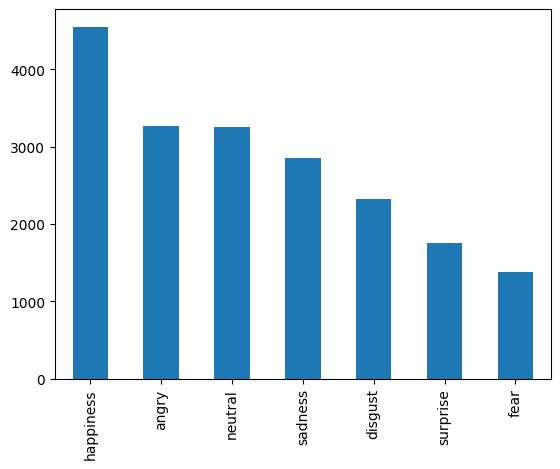

In [ ]:
df.sentiment.value_counts().plot.bar();

+ 성별

In [ ]:
df['gender'].value_counts()

female    15092
male       4282
Name: gender, dtype: int64

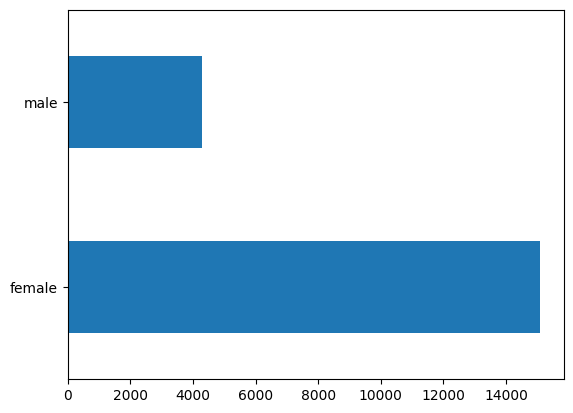

In [ ]:
df['gender'].value_counts().plot.barh();

### groupby()
+ 감정별 성별 비율

In [ ]:
df.groupby(['sentiment', 'gender'])['sentiment'].count()

sentiment  gender
angry      female    2649
           male       614
disgust    female    1718
           male       603
fear       female    1055
           male       331
happiness  female    3604
           male       944
neutral    female    2406
           male       847
sadness    female    2195
           male       653
surprise   female    1465
           male       290
Name: sentiment, dtype: int64

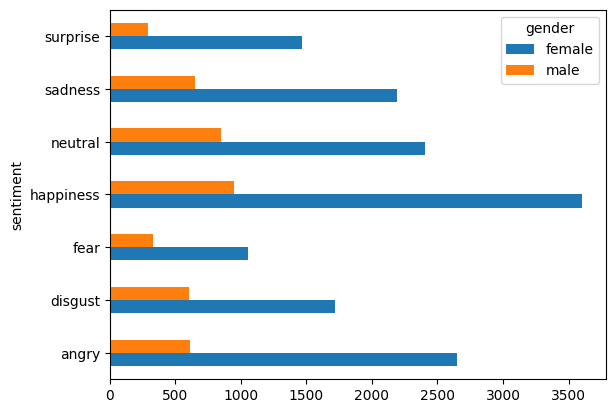

In [ ]:
df.groupby(['sentiment', 'gender'])['sentiment'].count().unstack().plot.barh();

### crosstab()
+ 감정별 성별 수

In [ ]:
pd.crosstab(df.gender, df['sentiment'], margins=True)\
.style.background_gradient(cmap='Greens')

sentiment,angry,disgust,fear,happiness,neutral,sadness,surprise,All
gender,,,,,,,,
female,2649,1718,1055,3604,2406,2195,1465,15092
male,614,603,331,944,847,653,290,4282
All,3263,2321,1386,4548,3253,2848,1755,19374


### wordcloud
+ 각 감정별 사용 빈도가 높은 단어 시각화

In [ ]:
from wordcloud import WordCloud, STOPWORDS # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
from matplotlib import font_manager, rc

In [ ]:
df['voice'] = df['voice'].str.replace('[^가-힣]', ' ', regex = True)
df['voice']

0                      에피타이저 정말 좋아해  그 것도 괜찮은 생각인 것 같애 
1                    난 부페 형식의 음식들도 정말 좋아해  그 것도 좀 알려 줘 
2              응  완전히 끝난 거야  한 달 동안 주말에 쉬지도 못하고 일만 했거든 
3        신나는 음악 듣는 것도 좋고  어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어 
4                      친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네 
                              ...                      
19369                                     써봤는데도 별로였더라고 
19370                             쓰레기통에서 역겨운 냄새가 나고 있어 
19371                          그거 때문에 집에서도 냄새가 나서 걱정이야 
19372                           방향제도 뿌려봤는데 냄새만 더 이상해졌어 
19373                                        걱정해줘서 고마워 
Name: voice, Length: 19374, dtype: object

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.9 MB/s eta 0:00:00


+ 나눔글꼴 설치

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum-extra.
(Reading database ... 123088 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-extra_20180306-3_all.deb ...
Unpacking fonts-nanum-extra (20180306-3) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-2_all.deb ...
Unpacking fonts-nanum-coding (2.5-2) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Setting up fonts-nanum-extra (20180306-3) ...
Setting up fonts-nanum-coding (2.5-2) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


In [ ]:
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [ ]:
import konlpy
kkma = konlpy.tag.Kkma() #형태소 분석기 꼬꼬마(Kkma)

# 명사 추출 함수 정의
def extract_nouns(text):
    nouns = kkma.nouns(text)
    return [noun for noun in nouns if len(noun) >= 2]

nouns = df['voice'].apply(extract_nouns)

In [ ]:
sentiment = df['sentiment']
df_word = pd.DataFrame({'word' : nouns, 'sentiment' : sentiment})
df_word.to_csv('wordcloud.csv', index = False)

In [ ]:
df_word = pd.read_csv("wordcloud.csv")
df_word.head()

,word,sentiment
0,"['에피타이저', '생각']",neutral
1,"['부페', '형식', '음식']",neutral
2,"['동안', '주말']",happiness
3,"['음악', '어디', '여행']",happiness
4,"['친구', '연락', '내가']",happiness


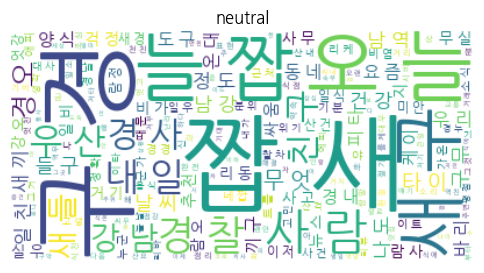

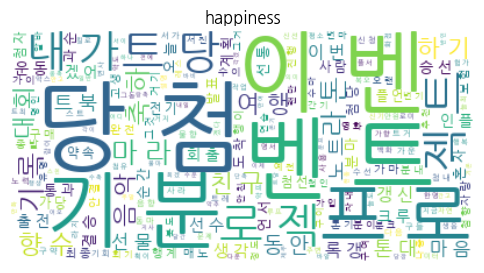

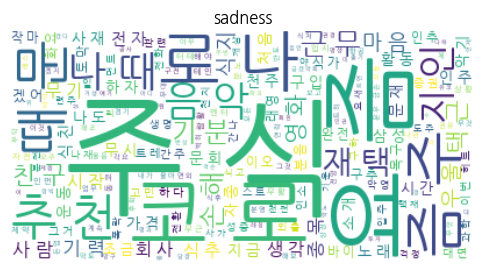

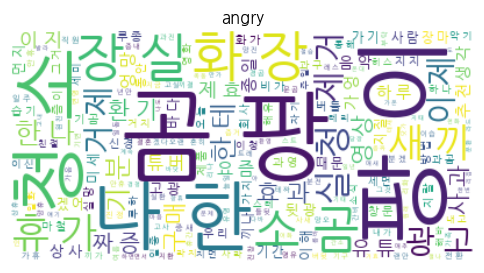

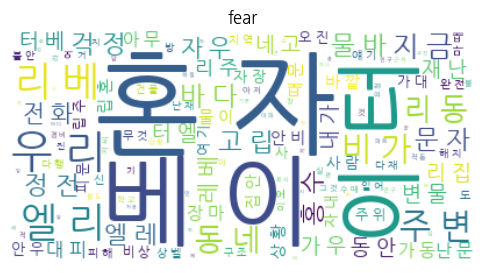

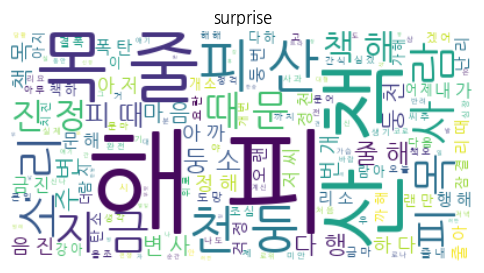

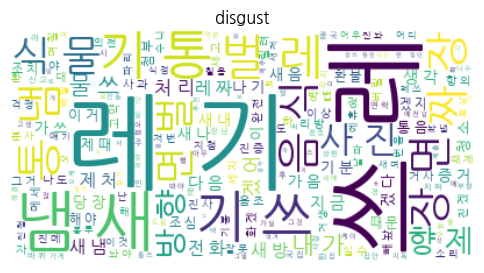

In [ ]:
# 글꼴 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 글꼴 설정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 감정별 워드클라우드 생성
sentiments = df_word['sentiment'].unique()
for sentiment in sentiments:
    words = [word for sublist in df_word[df_word['sentiment'] == sentiment]['word'] for word in sublist]
    words = ' '.join(words)

    # 워드클라우드 생성
    wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS, font_path=font_path)
    wordcloud.generate(words)

    # 워드클라우드 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

# BERT 모델
+ 트랜스포머 인코더를 일부 변형한 사전 학습 언어 모델
+ 마스크 언어 모델, 다음 문장인지 여부 맞추기와 같은 학습 테스크를 통해 모델이 순방향, 역방향 문맥 모두 볼 수 있도록 함
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FXeP8G%2FbtrqdTn7P9m%2F8SMBSsvoaGuaoTHkorMwIK%2Fimg.png' width="800" height ="" /><br>

+ 관련 대량 코퍼스 -> BERT -> 분류를 원하는 데이터 -> LSTM, CNN 등의 머신러닝 모델 -> 분류
+ 대량의 코퍼스를 Encoder가 임베딩하고(언어 모델링), 이를 전이하여 파인튜닝하고 Task를 수행
<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcEoPYe%2FbtqBW0v9pJo%2FxM7PQl9BL0XAKX9fYuphw1%2Fimg.png' width="800" height ="" /><br>

## 데이터 분할
+ 모델 학습을 위해 train, test로 분할하여 저장

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 분할
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# 분할된 데이터 저장
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

+ 분할한 데이터 로드

In [ ]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

(15499, 4)
(3875, 4)


In [ ]:
train = pd.read_csv('train.csv')
train.head()

,voice,sentiment,gender,label
0,에휴. 내가 잘못 해서 생긴 일이니까 얼른 청소 해야지.벌레가 생길까봐 걱정돼.,disgust,female,1
1,너무 지저분하고 더러워서 짜장면을 못 먹겠어. 버려야 할 것 같아.,disgust,female,1
2,그래야 될까 정말?,disgust,female,1
3,내 휴가가 엉망이야.,angry,female,0
4,내려가는 걸 눌렀는데 갑자기 탁 멈추면서 불이 지금 다 꺼지고. 야 완전 무서워. ...,fear,male,2


In [ ]:
sentences = train['voice']
sentences[:10]

0         에휴. 내가 잘못 해서 생긴 일이니까 얼른 청소 해야지.벌레가 생길까봐 걱정돼.
1                너무 지저분하고 더러워서 짜장면을 못 먹겠어. 버려야 할 것 같아.
2                                           그래야 될까 정말?
3                                          내 휴가가 엉망이야.
4    내려가는 걸 눌렀는데 갑자기 탁 멈추면서 불이 지금 다 꺼지고. 야 완전 무서워. ...
5                                            나 너무 우울해.
6                       그러니까. 새로 생긴 음식점에서 어떻게 그럴 수 있지?
7                                          사진 당연히 찍었지!
8                       향수 진짜 몇 명 안 주는 건데 그거 당첨됐다니까.\t
9                                    곰팡이 제거제가 효과가 있을까?
Name: voice, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 에휴. 내가 잘못 해서 생긴 일이니까 얼른 청소 해야지.벌레가 생길까봐 걱정돼. [SEP]',
 '[CLS] 너무 지저분하고 더러워서 짜장면을 못 먹겠어. 버려야 할 것 같아. [SEP]',
 '[CLS] 그래야 될까 정말? [SEP]',
 '[CLS] 내 휴가가 엉망이야. [SEP]',
 '[CLS] 내려가는 걸 눌렀는데 갑자기 탁 멈추면서 불이 지금 다 꺼지고. 야 완전 무서워. 이거 뭐야? [SEP]',
 '[CLS] 나 너무 우울해. [SEP]',
 '[CLS] 그러니까. 새로 생긴 음식점에서 어떻게 그럴 수 있지? [SEP]',
 '[CLS] 사진 당연히 찍었지! [SEP]',
 '[CLS] 향수 진짜 몇 명 안 주는 건데 그거 당첨됐다니까.\t [SEP]',
 '[CLS] 곰팡이 제거제가 효과가 있을까? [SEP]']

In [ ]:
labels = train['label'].values
labels

array([1, 1, 1, ..., 4, 0, 1])

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 에휴. 내가 잘못 해서 생긴 일이니까 얼른 청소 해야지.벌레가 생길까봐 걱정돼. [SEP]
['[CLS]', '에', '##휴', '.', '내', '##가', '잘', '##못', '해', '##서', '생', '##긴', '일', '##이', '##니', '##까', '얼', '##른', '청', '##소', '해', '##야', '##지', '.', '벌', '##레', '##가', '생', '##길', '##까', '##봐', '걱', '##정', '##돼', '.', '[SEP]']


In [ ]:
from keras.utils import pad_sequences

MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([   101,   9559, 119458,    119,   8996,  11287,   9654, 118940,
         9960,  12424,   9420,  70221,   9641,  10739,  25503, 118671,
         9551,  37819,   9751,  22333,   9960,  21711,  12508,    119,
         9339,  56645,  11287,   9420, 118666, 118671, 118990,   8864,
        16605, 118798,    119,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
import torch
from sklearn.model_selection import train_test_split

# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=2018,
                                                                                    test_size=0.2)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=2018,
                                                       test_size=0.2)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9651,  11664,   9641,  12965, 118718,  54141,  25503,   9604,
         12692,   9711,   9391,  11664,   9689, 118985,  10739,   9056,   9299,
         10530,   9655,  89045, 119192,  12965,    119,    102,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
test = pd.read_csv('test.csv')
test.head()

,voice,sentiment,gender,label
0,아휴 짭새 구경 갔다가 우산도 잃어버리고 왔어.,neutral,female,4
1,오늘부터 휴가 기간인데 휴가 기간 내내 비가 온대.,angry,female,0
2,내 휴가가 엉망이야.,angry,female,0
3,어. 무서워 죽겠어 진짜.,fear,male,2
4,응. 일단 여행부터 갈 거야.,happiness,male,3


In [ ]:
# 문장 추출
sentences = test['voice']
sentences[:10]

0           아휴 짭새 구경 갔다가 우산도 잃어버리고 왔어.
1         오늘부터 휴가 기간인데 휴가 기간 내내 비가 온대.
2                          내 휴가가 엉망이야.
3                       어. 무서워 죽겠어 진짜.
4                     응. 일단 여행부터 갈 거야.
5                               그래야겠지.
6         친구가 초밥을 좋아하니까 일식집이 괜찮을 것 같아.
7    구경하는 사람들이 너무 많아서 무슨 일인지 알 수가 없었어.
8              난 게임보다는 영화보는 걸 더 즐거워 해.
9                내가 쓰레기통은 제때 비우지 못 했어.
Name: voice, dtype: object

In [ ]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 아휴 짭새 구경 갔다가 우산도 잃어버리고 왔어. [SEP]',
 '[CLS] 오늘부터 휴가 기간인데 휴가 기간 내내 비가 온대. [SEP]',
 '[CLS] 내 휴가가 엉망이야. [SEP]',
 '[CLS] 어. 무서워 죽겠어 진짜. [SEP]',
 '[CLS] 응. 일단 여행부터 갈 거야. [SEP]',
 '[CLS] 그래야겠지. [SEP]',
 '[CLS] 친구가 초밥을 좋아하니까 일식집이 괜찮을 것 같아. [SEP]',
 '[CLS] 구경하는 사람들이 너무 많아서 무슨 일인지 알 수가 없었어. [SEP]',
 '[CLS] 난 게임보다는 영화보는 걸 더 즐거워 해. [SEP]',
 '[CLS] 내가 쓰레기통은 제때 비우지 못 했어. [SEP]']

In [ ]:
# 라벨 추출
labels = test['label'].values
labels

array([4, 0, 0, ..., 2, 3, 4])

In [ ]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 아휴 짭새 구경 갔다가 우산도 잃어버리고 왔어. [SEP]
['[CLS]', '아', '##휴', '[UNK]', '구', '##경', '갔', '##다가', '우', '##산', '##도', '잃', '##어', '##버', '##리고', '왔', '##어', '.', '[SEP]']


In [ ]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids[0]

array([   101,   9519, 119458,    100,   8908,  31720,   8852,  80244,
         9604,  21386,  12092,   9643,  12965,  41605,  62211,   9594,
        12965,    119,    102,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   9519, 119458,    100,   8908,  31720,   8852,  80244,   9604,
         21386,  12092,   9643,  12965,  41605,  62211,   9594,  12965,    119,
           102,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [ ]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 모델 생성

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from transformers import BertForSequenceClassification

# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=7)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
from transformers import get_linear_schedule_with_warmup

# 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5, # 학습률
                              eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                             )

# 에폭수
epochs = 8

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## 모델 학습



In [ ]:
import numpy as np

# 정확도 계산 함수
def flat_accuracy(preds, labels):

  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import datetime

# 시간 표시 함수
def format_time(elapsed):

  # 반올림
  elapsed_rounded = int(round((elapsed)))

  # hh:mm:ss으로 형태 변경
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import time

# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

  # Training
  print("Training...")

  # 시작 시간 설정
  t0 = time.time()

  # 로스 초기화
  total_loss = 0

  # 훈련모드로 변경
  model.train()

  # 데이터로더에서 배치만큼 반복하여 가져옴
  for step, batch in enumerate(train_dataloader):
    # 경과 정보 표시
    if step % 500 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Epoch: {:}/{:} | Batch: {:}/{:} | Elapsed: {:}.'.format(epoch_i + 1, epochs,
                                                                       step, len(train_dataloader),
                                                                       elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # Forward 수행
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

    # 로스 구함
    loss = outputs[0]

    # 총 로스 계산
    total_loss += loss.item()

    # Backward 수행으로 그래디언트 계산
    loss.backward()

    # 그래디언트 클리핑
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # 그래디언트를 통해 가중치 파라미터 업데이트
    optimizer.step()

    # 스케줄러로 학습률 감소
    scheduler.step()

    # 그래디언트 초기화
    model.zero_grad()

  # 평균 로스 계산
  avg_train_loss = total_loss / len(train_dataloader)

  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


  # Validation
  print("Validation...")

  #시작 시간 설정
  t0 = time.time()

  # 평가모드로 변경
  model.eval()

  # 변수 초기화
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # 데이터로더에서 배치만큼 반복하여 가져옴
  for batch in validation_dataloader:
    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
      # Forward 수행
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation took: {:}".format(format_time(time.time() - t0)))

Training...
  Average training loss: 0.78
  Training epcoh took: 0:04:18
Validation...
  Accuracy: 0.86
  Validation took: 0:00:22
Training...
  Average training loss: 0.35
  Training epcoh took: 0:04:20
Validation...
  Accuracy: 0.88
  Validation took: 0:00:22
Training...
  Average training loss: 0.25
  Training epcoh took: 0:04:20
Validation...
  Accuracy: 0.89
  Validation took: 0:00:22
Training...
  Average training loss: 0.19
  Training epcoh took: 0:04:21
Validation...
  Accuracy: 0.90
  Validation took: 0:00:22
Training...
  Average training loss: 0.14
  Training epcoh took: 0:04:20
Validation...
  Accuracy: 0.90
  Validation took: 0:00:22
Training...
  Average training loss: 0.11
  Training epcoh took: 0:04:20
Validation...
  Accuracy: 0.90
  Validation took: 0:00:22
Training...
  Average training loss: 0.09
  Training epcoh took: 0:04:20
Validation...
  Accuracy: 0.90
  Validation took: 0:00:22
Training...
  Average training loss: 0.06
  Training epcoh took: 0:04:21
Validation

## 모델 평가

In [ ]:
# Evaluation
print("Evaluation...")

#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
  # 경과 정보 표시
  if step % 100 == 0 and not step == 0:
    elapsed = format_time(time.time() - t0)
    print('  Batch: {:}/{:} | Elapsed: {:}.'.format(step, len(test_dataloader),
                                                    elapsed))

  # 배치를 GPU에 넣음
  batch = tuple(t.to(device) for t in batch)

  # 배치에서 데이터 추출
  b_input_ids, b_input_mask, b_labels = batch

  # 그래디언트 계산 안함
  with torch.no_grad():
    # Forward 수행
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  # 로스 구함
  logits = outputs[0]

  # CPU로 데이터 이동
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # 출력 로짓과 라벨을 비교하여 정확도 계산
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

Evaluation...
  Batch: 100/122 | Elapsed: 0:00:22.
Accuracy: 0.91
Test took: 0:00:27


## 테스트

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

  # BERT의 토크나이저로 문장을 토큰으로 분리
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  # 입력 토큰의 최대 시퀀스 길이
  MAX_LEN = 128

  # 토큰을 숫자 인덱스로 변환
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []

  # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
  # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

  # 데이터를 파이토치의 텐서로 변환
  inputs = torch.tensor(input_ids)
  masks = torch.tensor(attention_masks)

  return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

  # 평가모드로 변경
  model.eval()

  # 문장을 입력 데이터로 변환
  inputs, masks = convert_input_data(sentences)

  # 데이터를 GPU에 넣음
  b_input_ids = inputs.to(device)
  b_input_mask = masks.to(device)

  # 그래디언트 계산 안함
  with torch.no_grad():
    # Forward 수행
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  # 로스 구함
  logits = outputs[0]

  # CPU로 데이터 이동
  logits = logits.detach().cpu().numpy()

  return logits

'angry':0, 'disgust':1, 'fear':2, 'happiness':3, 'neutral':4, 'sadness':5, 'surprise':6

In [ ]:
logits = test_sentences(['둘 다 청소 하기 싫어. 귀찮아.'])

print(logits)
print(np.argmax(logits))

[[ 6.7844577  0.8752262 -1.2644314 -1.2506127 -1.7179917 -1.0630598
  -1.6193691]]
0


In [ ]:
logits = test_sentences(['응. 치워야 되는데 어떡하지? 누가 치우지도 않고 갔네?'])

print(logits)
print(np.argmax(logits))

[[-1.057489    6.653899   -1.0829989  -1.4963292  -0.8737375  -2.1449208
  -0.62209624]]
1


In [ ]:
logits = test_sentences(['정전이 났나봐 혼자 있어서 너무 무서워..'])

print(logits)
print(np.argmax(logits))

[[-1.3268713  -1.4815824   6.5899734  -0.79949594 -0.8271162  -1.3564315
  -0.74465656]]
2


In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

[[ 0.25105208 -1.4846222  -1.8182304   6.0225773  -1.2330123   0.3026827
  -2.4225833 ]]
3


In [ ]:
logits = test_sentences(['오늘 수업이 너무 많았어...피곤해'])

print(logits)
print(np.argmax(logits))

[[-1.4008871 -1.8151821 -1.9423045  2.1836991  5.536176  -1.5745118
  -1.671919 ]]
4


In [ ]:
logits = test_sentences(['내 친구는 발목을 다쳤거든. 다른 사람들은 잘 모르겠어.'])

print(logits)
print(np.argmax(logits))

[[-2.8138065  -2.6890974  -0.42497557  3.0423706  -1.6129675   3.3834877
   0.75754315]]
5


In [ ]:
logits = test_sentences(['어제 지진 있었잖아. 다행히 다치진 않았어.'])

print(logits)
print(np.argmax(logits))

[[-2.1020691 -1.048122   1.7482787 -1.8043522 -1.1109128 -1.5428784
   6.4190736]]
6
